<a href="https://colab.research.google.com/github/Zhr-Srj/TripSimAcin-AMR/blob/main/Code/TripSimAcin_AMR_PerDrug.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In this notebook we want to assess framework's performance on strain-aside-set (unseen strains) per drug.

This file includes results mentioned in file Figure 5 in article.

# Required packages

In [ ]:
import csv
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import random
from random import sample, shuffle

from sklearn.utils import shuffle as sk_shuffle

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score
from sklearn.metrics import auc as sk_auc


from tensorflow.keras.layers import Input, Dense, Dropout, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.callbacks import  History

# Data

## Loading dataset with SHAP selected features

In [ ]:
with open(r'/content/drive/MyDrive/Dataset_SHAP_u.txt') as f:
    data = []
    for line in f.readlines():
        row = []
        for elem in line.split(sep=','):
            row.append(int(elem.strip()))
        data.append(row)
print(len(data))
print(len(data[0]))

7207
2996


In [ ]:
#Reading phenotypes file
with open(r'/content/drive/MyDrive/DrugLabel_SHAP_u.txt') as fy:
    labels = []
    drugs = [] #stores drug name in each row
    row = 0 # row number of each label (is needed because data is reordered while spliting)
    reader = csv.reader(fy)
    for i in reader:
        labels.append([row, int(i[1])])
        drugs.append(i[0])
        row += 1

print(len(labels))
print(len(drugs))
print(labels[:5])

7207
7207
[[0, 1], [1, 0], [2, 0], [3, 1], [4, 1]]


In [ ]:
labels = np.asarray(labels)

## A survey on data

In [ ]:
unq_drugs = set(drugs)
len(unq_drugs)

12

In [ ]:
per_drug_dic = {}
for i, drug in enumerate(drugs_unique):
  if drug not in per_drug_dic.keys():
    per_drug_dic[drug] = [0, 0]  # num of resistant, num of susceptible
  if labels[i][1] == 0:
    per_drug_dic[drug][1] += 1
  else:
    per_drug_dic[drug][0] += 1

per_drug_dic

{'ciprofloxacin': [547, 201],
 'doripenem': [144, 55],
 'gentamicin': [491, 175],
 'tetracycline': [492, 201],
 'cefotaxime': [438, 161],
 'meropenem': [242, 96],
 'imipenem': [482, 222],
 'amikacin': [485, 209],
 'levofloxacin': [438, 167],
 'ceftriaxone': [486, 181],
 'ceftazidime': [440, 191],
 'moxifloxacin': [60, 26]}

In [ ]:
keys = []
for element in data:
  if np.asarray(element[:2693]).tobytes() not in keys:
    keys.append(np.asarray(element[:2693]).tobytes())

print("Number of strains in dataset", len(keys))

Number of strains in dataset 766


## Loading strain-aside dataset

In [ ]:
f1 = open(r'/content/drive/MyDrive/Strain_aside_Dataset_SHAP.txt')

external_test_set = []

for line in f1.readlines():
    row = []
    for elem in line.split(sep=','):
        row.append(int(elem.strip()))
    external_test_set.append(row)

print(len(external_test_set))
print(len(external_test_set[0]))

f1.close()

1371
2996


In [ ]:
#Reading phenotypes file
with open(r'/content/drive/MyDrive/Strain_aside_drugLabel_SHAP.txt') as fy:
    external_test_labels = []
    external_test_drugs = [] #stores drug name in each row
    row = 0 # row number of each label (is needed because data is reordered while spliting)
    reader = csv.reader(fy)
    for i in reader:
        external_test_labels.append([row, int(i[1])])
        external_test_drugs.append(i[0])
        row += 1

print(len(external_test_labels))
print(len(external_test_drugs))
print(external_test_labels[:5])

1371
1371
[[0, 1], [1, 1], [2, 1], [3, 1], [4, 1]]


In [ ]:
external_test_labels = np.asarray(external_test_labels)

In [ ]:
len(set(external_test_drugs))

10

In [ ]:
set(external_test_drugs)

{'amikacin',
 'cefotaxime',
 'ceftazidime',
 'ceftriaxone',
 'ciprofloxacin',
 'gentamicin',
 'imipenem',
 'levofloxacin',
 'meropenem',
 'tetracycline'}

In [ ]:
unq_drugs = set(external_test_drugs)
len(unq_drugs)

10

In [ ]:
per_drug_dic = {}
for i, drug in enumerate(external_test_drugs):
  if drug not in per_drug_dic.keys():
    per_drug_dic[drug] = [0, 0]  # num of resistant, num of susceptible
  if external_test_labels[i][1] == 0:
    per_drug_dic[drug][1] += 1
  else:
    per_drug_dic[drug][0] += 1

per_drug_dic

{'ciprofloxacin': [211, 23],
 'gentamicin': [202, 35],
 'ceftriaxone': [206, 4],
 'amikacin': [181, 26],
 'ceftazidime': [211, 14],
 'meropenem': [75, 6],
 'levofloxacin': [66, 6],
 'imipenem': [75, 6],
 'tetracycline': [14, 0],
 'cefotaxime': [10, 0]}

# Data preparation functions

In [ ]:
def make_balanced_triplets(samples, labels, drugs, num):
  """For each drug in drugs samples...
  makes:
  - n triplets which are both Susceptible to drug (S, S)
  - n triplets which are (R, R)
  - n triplets which are (S, R)
  - n triplets which are (R, S)
  """
  bac_shape = 2693

  idx = {} # A dic containig indices of susceptible and resistant strain
            # for each drug

  triplet = [] # Made from samples which are not part of external_test_sets
  triLabels = [] # Labels corresponding to triplets

  unq_drugs = list(set(drugs))

  for drug_name in unq_drugs:
    drug_indx_S = []
    drug_indx_R = []
    for i in range(len(labels)):
      j, l = labels[i][0], labels[i][1]
      if drugs[j] == drug_name:
        if l == 0:
          drug_indx_S.append(i)
        else:
          drug_indx_R.append(i)
    idx[(drug_name, 'S')] = drug_indx_S
    idx[(drug_name, 'R')] = drug_indx_R

  for drug in unq_drugs:

    s_len = len(idx[(drug, 'S')])
    r_len = len(idx[(drug, 'R')])
    n = min(num, int(s_len*(s_len-1)/2), int(r_len*(r_len-1)/2))

    ss = [(i, j) for i in idx[(drug, 'S')] for j in idx[(drug, 'S')] if j>i]
    ss_sampled = sample(ss, n)

    rr = [(i, j) for i in idx[(drug, 'R')] for j in idx[(drug, 'R')] if j>i]
    rr_sampled = sample(rr, n)

    rs = [(i, j) for i in idx[(drug, 'R')] for j in idx[(drug, 'S')]]
    neg_samples = sample(rs, 2*n)
    rs_sampled = neg_samples[:n]
    sr_sampled = [(t[1], t[0]) for t in neg_samples[n:]]

    for k in range(n):
      # Making (S, S, d) triplets
      triplet.append( samples[ss_sampled[k][0]][:bac_shape] + samples[ss_sampled[k][1]][:bac_shape] +
                        samples[ss_sampled[k][0]][bac_shape:] )
      triLabels.append([1, 0]) # 1: both phenos the same. First: 0, sencond? --> 0

      # Making (R, R, d) triplets
      triplet.append( samples[rr_sampled[k][0]][:bac_shape] + samples[rr_sampled[k][1]][:bac_shape] +
                        samples[rr_sampled[k][0]][bac_shape:] )
      triLabels.append([1, 1]) # 1: both phenos the same. First: 1, sencond? --> 1

      # Making (R, S, d) triplets
      triplet.append( samples[rs_sampled[k][0]][:bac_shape] + samples[rs_sampled[k][1]][:bac_shape] +
                         samples[rs_sampled[k][0]][bac_shape:])
      triLabels.append([0, 1]) # 0: phenos different. First: 1, sencond? --> 0

      # Making (S, R, d) triplets
      triplet.append( samples[sr_sampled[k][0]][:bac_shape] + samples[sr_sampled[k][1]][:bac_shape] +
                         samples[sr_sampled[k][0]][bac_shape:])
      triLabels.append([0, 0]) # 0: phenos different. First: 0, sencond? --> 1

  return np.array(triplet), np.array(triLabels)

# TripSimAcin-AMR framework

## TSA-Net architecture

In [ ]:
def create_siamese_model(input_shape1, input_shape2, input_shape3):

    right_input = Input(shape=input_shape2)
    left_input = Input(shape=input_shape1)
    third_input = Input(shape=input_shape3)

    shared_layer1 = Dense(1024, activation='leaky_relu')
    shared_layer2 = Dense(512, activation='leaky_relu')
    shared_layer3 = Dense(256, activation='leaky_relu')
    shared_bn = BatchNormalization() # shared batch normalization layer
    drug_bn = BatchNormalization() # drug batch normalization layer

    encoded_l = shared_layer1(left_input)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_layer2(encoded_l)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_layer3(encoded_l)
    encoded_l = Dropout(0.2)(encoded_l)
    encoded_l = shared_bn(encoded_l)

    encoded_r = shared_layer1(right_input)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_layer2(encoded_r)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_layer3(encoded_r)
    encoded_r = Dropout(0.2)(encoded_r)
    encoded_r = shared_bn(encoded_r)

    encoded_c = Dense(256, activation='leaky_relu')(third_input)
    encoded_c = Dropout(0.2)(encoded_c)
    encoded_c = drug_bn(encoded_c)

    concatenated = Concatenate()([encoded_l, encoded_r, encoded_c])

    dense1 = Dense(128, activation='leaky_relu')(concatenated)
    dense1 = Dropout(0.2)(dense1)
    dense2 = Dense(32, activation='leaky_relu')(dense1)
    dense2 = Dropout(0.2)(dense2)
    prediction = Dense(1, activation='sigmoid')(dense2)

    siamese_net = Model(inputs=[left_input, right_input, third_input], outputs=prediction)

    optimizer = Adam(learning_rate=0.001)
    siamese_net.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=["accuracy", AUC(name='auc-roc')])

    return siamese_net

In [ ]:
input_shape1 = (2693,)
input_shape2 = (2693,)
input_shape3 = (303,)

# Evaluation

## Functions

In [ ]:
def evaluation(true_labels, pred_labels):

  Dis_pred = []
  for i in pred_labels:
    if i < 0.5:
      Dis_pred.append(0)
    else:
      Dis_pred.append(1)

  acc = accuracy_score(true_labels, Dis_pred)
  auc = roc_auc_score(true_labels, Dis_pred)
  print('Accuracy: ', acc)
  print('ROC-AUC: ', auc)

  TN, FP, FN, TP = confusion_matrix(true_labels, Dis_pred, labels=[0, 1]).ravel()
  sen = TP/(TP+FN)
  spc = TN/(TN+FP)
  print("Sensitivity: ", sen)
  print('Specificity: ', spc)

  print("# of TPs: ", TP)
  print("# of FPs: ", FP)
  print("# of TNs: ", TN)
  print("# of FNs: ", FN)

  conf_matrix = confusion_matrix(true_labels, Dis_pred, labels=[0, 1])
  plt.figure(figsize=(4, 4))
  sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
              xticklabels=['Predicted Negative', 'Predicted Positive'],
              yticklabels=['True Negative', 'True Positive'])
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()

  return acc, auc, sen, spc, TN, FP, FN, TP

In [ ]:
def EvalPerDrug(y_test, y_pred, indices, drugs, cutoff=0.5):

  acc = []
  auc = []
  sen = []
  spe = []
  TNs = []
  FPs = []
  FNs = []
  TPs = []

  Dis_Pred=[]
  for i in range(len(y_pred)):
    if (y_pred[i]>cutoff):
      Dis_Pred.append(1)
    else:
      Dis_Pred.append(0)
  y_pred=np.array(Dis_Pred)

  drug_list = []
  for i in indices:
    drug_list.append( drugs[i] )

  unq_drugs = sorted( list(set(drug_list)) )

  for drug in unq_drugs:
    current_test = []
    current_pred = []
    #*********************************
    for i in range(len(y_pred)):
      if drugs[indices[i]] == drug:
        current_test.append(y_test[i])
        current_pred.append(y_pred[i])

    current_test = np.array(current_test)

    acc.append(accuracy_score(current_test, current_pred))
    auc.append(roc_auc_score(current_test, current_pred))

    TN, FP, FN, TP = confusion_matrix(current_test, current_pred, labels=[0, 1]).ravel()

    sen.append(TP/(TP+FN))
    spe.append(TN/(TN+FP))

    TNs.append(TN)
    TPs.append(TP)
    FPs.append(FP)
    FNs.append(FN)

  return unq_drugs, acc, auc, sen, spe, TNs, FPs, FNs, TPs

In [ ]:
def plot_curves(true_labels, pred_labels):

  # Compute ROC curve and ROC area
  fpr, tpr, _ = roc_curve(true_labels, pred_labels)
  roc_auc = sk_auc(fpr, tpr)

  # Compute Precision-Recall curve and average precision
  precision, recall, _ = precision_recall_curve(true_labels, pred_labels)
  average_precision = average_precision_score(true_labels, pred_labels)

  # Plot and save ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('Receiver Operating Characteristic Curve')
  plt.legend(loc="lower right")
  plt.savefig('/content/drive/MyDrive/roc_curve.png')  # Save the ROC curve as a PNG file
  plt.show()

  # Plot and save Precision-Recall curve
  plt.figure()
  plt.plot(recall, precision, color='blue', lw=2, label='PR curve (area = %0.2f)' % average_precision)
  plt.xlabel('Recall')
  plt.ylabel('Precision')
  plt.title('Precision-Recall Curve')
  plt.legend(loc="lower left")
  plt.savefig('/content/drive/MyDrive/pr_curve.png')  # Save the PR curve as a PNG file
  plt.show()

In [ ]:
def ExternalTest(x0_test,x1_test,x0_train,x1_train):
  """
  Takes as input paired data and
  makes each test sample pair with train samples of the same drug (triplet --> b1, b2, d).
  x0_test: test samples with phenotype 0
  x1_test: test samples with phenotype 1
  x0_train: train samples with phenotype 0
  x1_train: train samples with phenotype 1
  """
  dataset_test1=[] # concat train
  label_test1=[]
  Indexsample=[]

  for i in range(len(x0_test)):
    for j in range(len(x0_train)):
      if (x0_test[i][2693:] == x0_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x0_test[i][0:2693],x0_train[j]), axis=None))
        label_test1.append(1)
        Indexsample.append(str(i)+",0,0")   #index in test, x0_test pheno, x0_train pheno
  # print(len(dataset_test1))
  # print('0-0 acomplished')

  for i in range(len(x0_test)):
    for j in range(len(x1_train)):
      if (x0_test[i][2693:] == x1_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x0_test[i][0:2693],x1_train[j]), axis=None))
        label_test1.append(0)
        Indexsample.append(str(i)+",0,1")   #index in test, x0_test pheno, x1_train pheno
  # print(len(dataset_test1))
  # print('0-1 acomplished')

  for i in range(len(x1_test)):
    for j in range(len(x0_train)):
      if (x1_test[i][2693:] == x0_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x1_test[i][0:2693],x0_train[j]), axis=None))
        label_test1.append(0)
        Indexsample.append(str(i)+",1,0")  #index in test,x1_test,x0_train
  # print(len(dataset_test1))
  # print('1-0 acomplished')

  for i in range(len(x1_test)):
    for j in range(len(x1_train)):
      if (x1_test[i][2693:] == x1_train[j][2693:]).all():
        dataset_test1.append(np.concatenate((x1_test[i][0:2693],x1_train[j]), axis=None))
        label_test1.append(1)
        Indexsample.append(str(i)+",1,1")  #index in test,x1_test,x1_train

  return (np.asarray(dataset_test1), np.asarray(label_test1), Indexsample)

In [ ]:
def DefineTest2(x0_test, x1_test, Indexsample, y_pred):
  """
  Aggregates labels predicted by TSA_Net to get a unified prediction of resistence
  phenotype (Desired output for TripSimAcin_AMR)
  """
  Pred=[]
  Label=[]

  # START of x0_test
  for i in range(len(x0_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0

    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #index test
        if int(triplet[1])==0: #type test

          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1

          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1

    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(0)

  # END of x0_test
  ######################################################
  # START of x1_test
  for i in range(len(x1_test)):
    cnt0Pred=0
    cnt1Pred=0
    cnt1=0
    cnt0=0
    for j in range(len(Indexsample)):
      triplet=Indexsample[j].split(",")   #pair[0] is index from test, pair[1] identifies which test x0_test or s1_test, pair[2] identifies which x0
      if int(triplet[0])==i: #index test
        if int(triplet[1])==1: #type test

          if int(triplet[2])==0: #type train
              cnt0Pred=cnt0Pred+y_pred[j]
              cnt0=cnt0+1

          if int(triplet[2])==1: #type train
              cnt1Pred=cnt1Pred+y_pred[j]
              cnt1=cnt1+1

    pos=(1-(cnt0Pred/cnt0))+(cnt1Pred/cnt1)
    neg=(cnt0Pred/cnt0)+(1-(cnt1Pred/cnt1))
    Pred.append(pos/(pos+neg))
    Label.append(1)

  return(Pred,Label)

In [ ]:
def RS_splitter(data, labels):
  """
  Takes as input a dataset and corresponding labels
  returns data0, data1
  which are set of susceptible and resistant strains in data, respectively
  """
  data0 = [] # list of susceptible strains' features
  data1 = [] # list of resistant strains' features
  index0 = [] # indices in original data
  index1 = [] # indices in original data

  for i, l in enumerate(labels):
    if l[1] == 0:
      data0.append(data[i])
      index0.append(l[0])
    else:
      data1.append(data[i])
      index1.append(l[0])

  return data0, data1, index0, index1

In [ ]:
# Making triplets
triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

In [ ]:
print(len(triplet))
print(len(triplet[0]))
print(len(pairedLabels))
print(pairedLabels[0])

19200
5689
19200
[1 0]


Preparing data

In [ ]:
triplet = np.asarray(triplet)
triplet.shape

(19200, 5689)

In [ ]:
pairedLabels = np.asarray(pairedLabels)
pairedLabels.shape

(19200, 2)

Training

In [ ]:
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

In [ ]:
num_epochs=10
history=History()
siamese_net = create_siamese_model(input_shape1, input_shape2, input_shape3)

print("Round: 1 ---> 1-10")
history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

for i in range(20-1):
  print("Round: ", i+2, '--->', (i+1)*10+1, '-', (i+2)*10)

  triplet, pairedLabels =  make_balanced_triplets(data, labels, drugs, 400)

  history = siamese_net.fit([[triplet[:, :2693],
                           triplet[:, 2693:(2693+2693)]],
                           triplet[:, (2693+2693):]], pairedLabels[:, 0],
                          epochs=num_epochs, batch_size=64, verbose=1, callbacks=history)

Round: 1 ---> 1-10
Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_79', 'keras_tensor_78', 'keras_tensor_80']
Received: inputs=(('Tensor(shape=(64, 2693))', 'Tensor(shape=(64, 2693))'), 'Tensor(shape=(64, 303))')
  warnings.warn(msg)


300/300 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.4975 - auc-roc: 0.4902 - loss: 0.8082
Epoch 2/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.5000 - auc-roc: 0.5040 - loss: 0.7090
Epoch 3/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5056 - auc-roc: 0.5103 - loss: 0.7020
Epoch 4/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5468 - auc-roc: 0.5813 - loss: 0.6704
Epoch 5/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.7380 - auc-roc: 0.8370 - loss: 0.4905
Epoch 6/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.7695 - auc-roc: 0.8626 - loss: 0.4569
Epoch 7/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.7894 - auc-roc: 0.8807 - loss: 0.4356
Epoch 8/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8123 - auc-roc: 0.8978 - loss: 0.4049
Epoch 9/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8310 - auc-roc: 0.9153 - loss: 0.3693
Epoch 10/10
300/300 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.8404 - 

## Validation

In [ ]:
test_labels = np.asarray(external_test_labels)
train_labels = np.asarray(labels)

In [ ]:
# splitting external_test_set to set of susceptible and resistant ones:
x0_test, x1_test, index0_test, index1_test = RS_splitter(external_test_set, test_labels)

In [ ]:
print(len(x0_test))
print(len(x0_test[0]))
print(len(x1_test))
print(len(x1_test[0]))

120
2996
1251
2996


In [ ]:
x0_train, x1_train, index0_train, index1_train = RS_splitter(data, labels)

In [ ]:
print(len(x0_train))
print(len(x0_train[0]))
print(len(x1_train))
print(len(x1_train[0]))

1940
2996
4690
2996


In [ ]:
x0_train = np.asarray(x0_train)
x1_train = np.asarray(x1_train)

## Procedure (Per test sample)

In [ ]:
test_labels = []  # True labels for test samples.
aggre_preds = [] # Aggregated pred values for each sample, by DefineTest2 func.
internal_labels = [] # Labels form ExternalTest2 for internal test
internal_preds = [] # internal_labels corresponding predictions
test_indices = []

for c, i in enumerate(x0_test):      #x0_test, x1_test, x0_train, x1_train
  data, labels, indexSample = ExternalTest([i], [], x0_train, x1_train) # makes i couple with x0_train & x1_train
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([i], [], indexSample, predd)
  aggre_preds.append(y_pred[0][0]) # y_pred ---> [array([0.5], dtype=float32)]
  test_labels.append(label[0])
  test_indices.append(index0_test[c]) # Index in original data

for c, i in enumerate(x1_test):
  data, labels, indexSample = ExternalTest([], [i], x0_train, x1_train)
  internal_labels += labels.tolist()
  predd = siamese_net.predict([[data[:, :2693],
                           data[:, 2693:(2693+2693)]],
                           data[:, (2693+2693):]], verbose=0)
  internal_preds += predd.tolist()
  y_pred, label = DefineTest2([], [i], indexSample, predd)
  aggre_preds.append(y_pred[0][0])
  test_labels.append(label[0])
  test_indices.append(index1_test[c]) # Index in original data

In [ ]:
temp = [i[0] for i in internal_preds]
internal_preds = temp

## TSA-Net evaluation

(Similarity test)

Accuracy:  0.9049123783155312
ROC-AUC:  0.8768397461466372
Sensitivity:  0.9434648483922182
Specificity:  0.8102146439010561
# of TPs:  604944
# of FPs:  49541
# of TNs:  211496
# of FNs:  36250


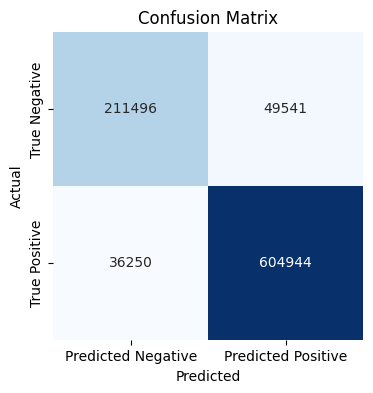

In [ ]:
acc, auc, sen, spc, _, _, _, _ = evaluation(internal_labels, internal_preds)

## Phenotype prediction test

Accuracy:  0.912472647702407
ROC-AUC:  0.786290967226219
Sensitivity:  0.9392486011191047
Specificity:  0.6333333333333333
# of TPs:  1175
# of FPs:  44
# of TNs:  76
# of FNs:  76


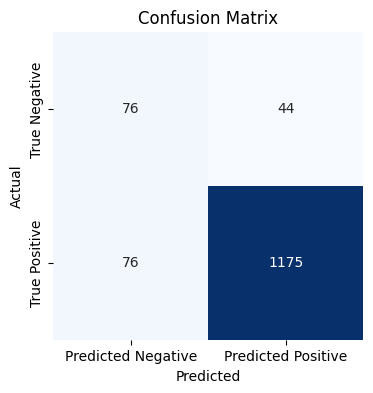

In [ ]:
acc, auc, sen, spc, TN, FP, FN, TP = evaluation(test_labels, aggre_preds)

## Curves

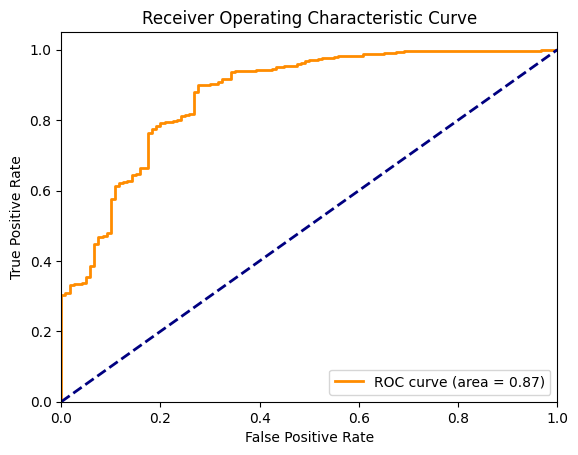

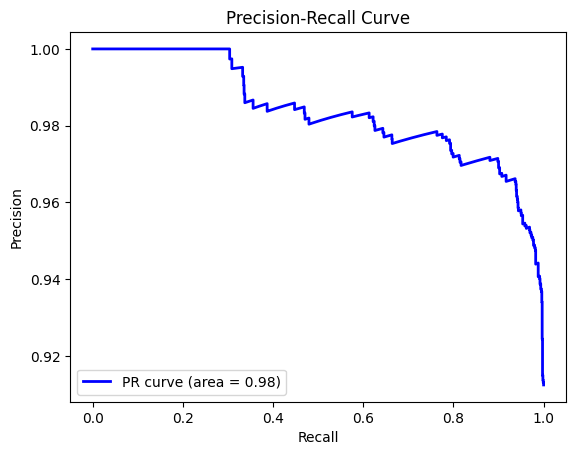

In [ ]:
plot_curves(test_labels, aggre_preds)

## Per-drug evaluation

In [ ]:
unq_drugs, acc, auc, sen, spc, TN, FP, FN, TP = EvalPerDrug(test_labels, aggre_preds, test_indices, external_test_drugs)

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
<ipython-input-74-41fa3bb299a2>:43: RuntimeWarning: invalid value encountered in scalar divide
  spe.append(TN/(TN+FP))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:379: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
<ipython-input-74-41fa3bb299a2>:43: RuntimeWarning: invalid value encountered in scalar divide
  spe.append(TN/(TN+FP))


In [ ]:
print('Drug names: ', unq_drugs)
print('ACCs: ', acc)
print('AUCs: ', auc)
print('SENs: ', sen)
print("SPC: ", spc)
print('TPs: ', TP)
print('TNs: ', TN)
print('FPs: ', FP)
print('FNs: ', FN)

Drug names:  ['amikacin', 'cefotaxime', 'ceftazidime', 'ceftriaxone', 'ciprofloxacin', 'gentamicin', 'imipenem', 'levofloxacin', 'meropenem', 'tetracycline']
ACCs:  [0.7536231884057971, 1.0, 0.9511111111111111, 0.9857142857142858, 0.9017094017094017, 0.9156118143459916, 0.9259259259259259, 1.0, 0.9259259259259259, 1.0]
AUCs:  [0.7932426689332768, nan, 0.740521327014218, 0.7475728155339806, 0.7324335462600453, 0.7142857142857143, 0.96, 1.0, 0.96, nan]
SENs:  [0.7403314917127072, 1.0, 0.981042654028436, 0.9951456310679612, 0.943127962085308, 1.0, 0.92, 1.0, 0.92, 1.0]
SPC:  [0.8461538461538461, nan, 0.5, 0.5, 0.5217391304347826, 0.42857142857142855, 1.0, 1.0, 1.0, nan]
TPs:  [134, 10, 207, 205, 199, 202, 69, 66, 69, 14]
TNs:  [22, 0, 7, 2, 12, 15, 6, 6, 6, 0]
FPs:  [4, 0, 7, 2, 11, 20, 0, 0, 0, 0]
FNs:  [47, 0, 4, 1, 12, 0, 6, 0, 6, 0]


In [ ]:
acc = [0.75, 1.0, 0.95, 0.98, 0.90, 0.91, 0.92, 1.0, 0.92, 1.0]
auc = [0.79, -0.1, 0.74, 0.74, 0.73, 0.71, 0.96, 1.0, 0.96, -0.1]
sen = [0.74, 1.0, 0.98, 0.99, 0.94, 1.0, 0.92, 1.0, 0.92, 1.0]
spc = [0.84, -0.1, 0.5, 0.5, 0.52, 0.42, 1.0, 1.0, 1.0, -0.1]

In [ ]:
TP = [134, 10, 207, 205, 199, 202, 69, 66, 69, 14]
TN = [22, 0, 7, 2, 12, 15, 6, 6, 6, 0]
FP = [4, 0, 7, 2, 11, 20, 0, 0, 0, 0]
FN = [47, 0, 4, 1, 12, 0, 6, 0, 6, 0]

In [ ]:
unq_drugs = ['AKN', 'CTM', 'CZM', 'CXN', 'CFN', 'GMN', 'IPM', 'LFN', 'MPM', 'TCN']

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

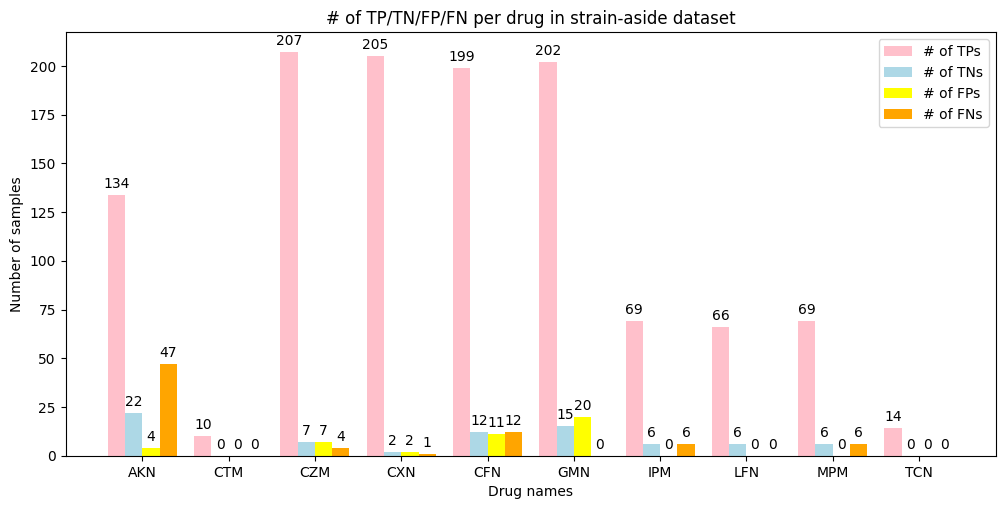

In [ ]:
fig, ax = plt.subplots(figsize=(12, 5.5))
bar_width = 0.2
x = np.arange(len(unq_drugs))

# Grouped Bar Plot
TPs = plt.bar(x - 1.5*bar_width, TP, bar_width, label='# of TPs', color='pink')
TNs = plt.bar(x - 0.5*bar_width, TN, bar_width, label='# of TNs', color='lightblue')
FPs = plt.bar(x + 0.5*bar_width, FP, bar_width, label='# of FPs', color='yellow')
FNs = plt.bar(x + 1.5*bar_width, FN, bar_width, label='# of FNs', color='orange')

# Adding labels and title
plt.xlabel('Drug names')
plt.ylabel('Number of samples')
plt.title('# of TP/TN/FP/FN per drug in strain-aside dataset')
plt.xticks(x, unq_drugs)
plt.legend()

# Adding annotations
def add_annotations(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

add_annotations(ax, TPs)
add_annotations(ax, TNs)
add_annotations(ax, FPs)
add_annotations(ax, FNs)

plt.savefig("/content/drive/MyDrive/TPTNFPFN.png")

plt.show()

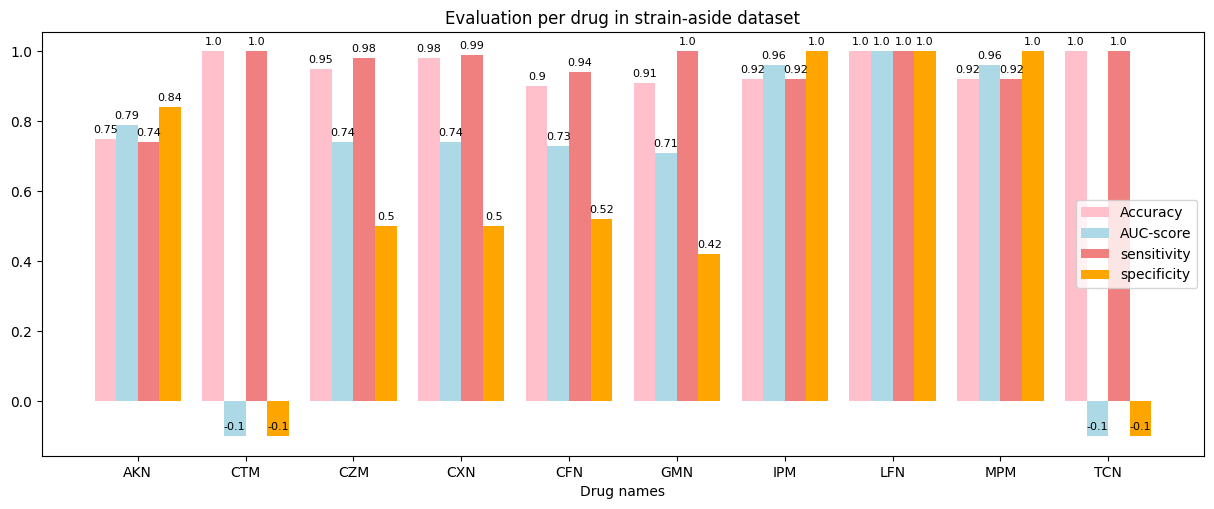

In [ ]:
fig, ax = plt.subplots(figsize=(15, 5.5))
bar_width = 0.2
x = np.arange(len(unq_drugs))

# Grouped Bar Plot
acc_bar = plt.bar(x - 1.5*bar_width, acc, bar_width, label='Accuracy', color='pink')
auc_bar = plt.bar(x - 0.5*bar_width, auc, bar_width, label='AUC-score', color='lightblue')
sen_bar = plt.bar(x + 0.5*bar_width, sen, bar_width, label='sensitivity', color='lightcoral')
spc_bar = plt.bar(x + 1.5*bar_width, spc, bar_width, label='specificity', color='orange')

# Adding labels and title
plt.xlabel('Drug names')
plt.ylabel('')
plt.title('Evaluation per drug in strain-aside dataset')
plt.xticks(x, unq_drugs)
plt.legend()

# Adding annotations
def add_annotations(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

add_annotations(ax, acc_bar)
add_annotations(ax, auc_bar)
add_annotations(ax, sen_bar)
add_annotations(ax, spc_bar)

plt.savefig("/content/drive/MyDrive/Metrics.png")

plt.show()